# Alpha-Bank Hackathon

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

In [3]:
tscv = TimeSeriesSplit(n_splits=10)

In [4]:
MSK_train = pd.read_csv('MSK_train.csv', sep=';')

In [5]:
MSK_train.head()

,0_ID,1_TIME,BID_P_1,BID_V_1,BID_P_2,BID_V_2,BID_P_3,BID_V_3,BID_P_4,BID_V_4,...,ASK_V_6,ASK_P_7,ASK_V_7,ASK_P_8,ASK_V_8,ASK_P_9,ASK_V_9,ASK_P_10,ASK_V_10,Y
0,TEA,1970.01.01 01:11:29.966690,2418,7,2417,3,2416,3,2415,3,...,1.0,2431.0,2.0,2436.0,1.0,2437.0,1.0,2438.0,1.0,0.419566
1,TEA,1970.01.01 01:11:32.444868,2418,7,2417,3,2416,3,2415,4,...,1.0,2431.0,2.0,2436.0,1.0,2437.0,1.0,2438.0,1.0,0.420918
2,TEA,1970.01.01 01:11:33.886045,2420,1,2418,7,2417,3,2416,3,...,1.0,2431.0,2.0,2436.0,1.0,2437.0,1.0,2438.0,1.0,0.420918
3,TEA,1970.01.01 01:11:36.895255,2420,1,2418,7,2417,4,2416,3,...,1.0,2431.0,2.0,2436.0,1.0,2437.0,1.0,2438.0,1.0,0.413503
4,COFFEE,1970.01.01 01:21:29.006102,128694,53,128693,150,128692,107,128691,123,...,88.0,128701.0,172.0,128702.0,192.0,128703.0,155.0,128704.0,213.0,NaN


In [6]:
MSK_train.index = pd.to_datetime(MSK_train['1_TIME'])

In [7]:
tea_agg = MSK_train[MSK_train['0_ID']=='TEA'].resample('1Min').apply(np.mean)
coffee_agg = MSK_train[MSK_train['0_ID']=='COFFEE'].resample('1Min').apply(np.mean)

In [8]:
tea_agg = tea_agg.interpolate()

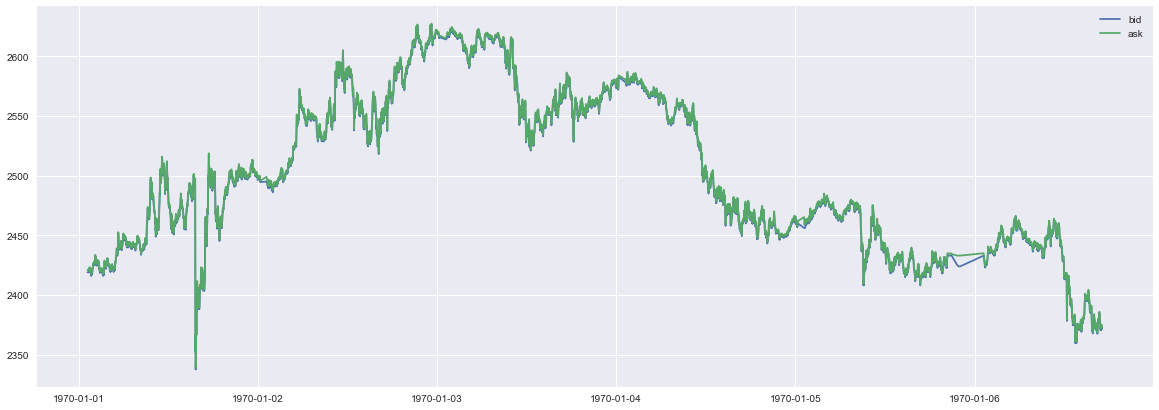

In [9]:
plt.figure(figsize=(20, 7))
plt.plot(tea_agg.BID_P_1, label='bid')
plt.plot(tea_agg.ASK_P_1, label='ask')
plt.legend()

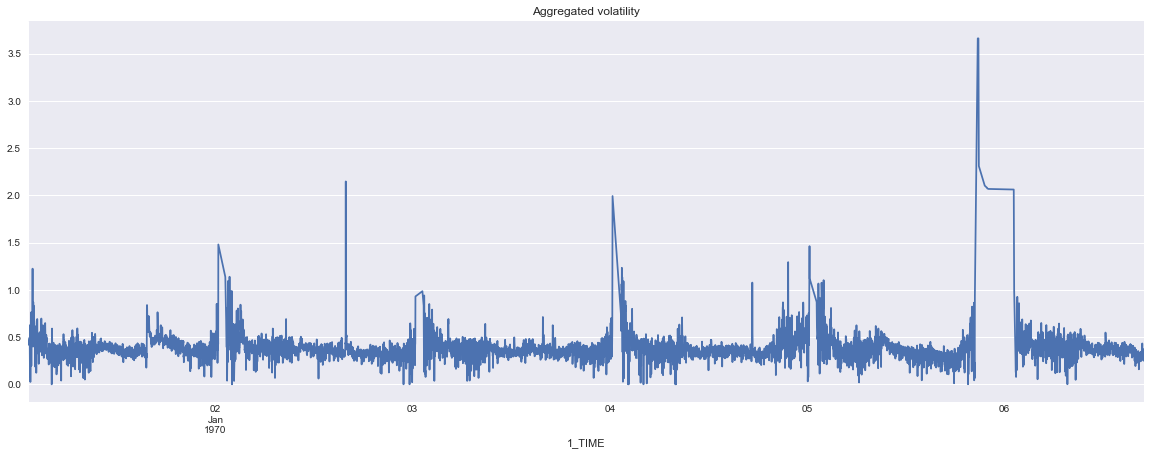

In [10]:
plt.figure(figsize=(20, 7))
tea_agg.Y.plot()
plt.title('Aggregated volatility')

In [11]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.594571


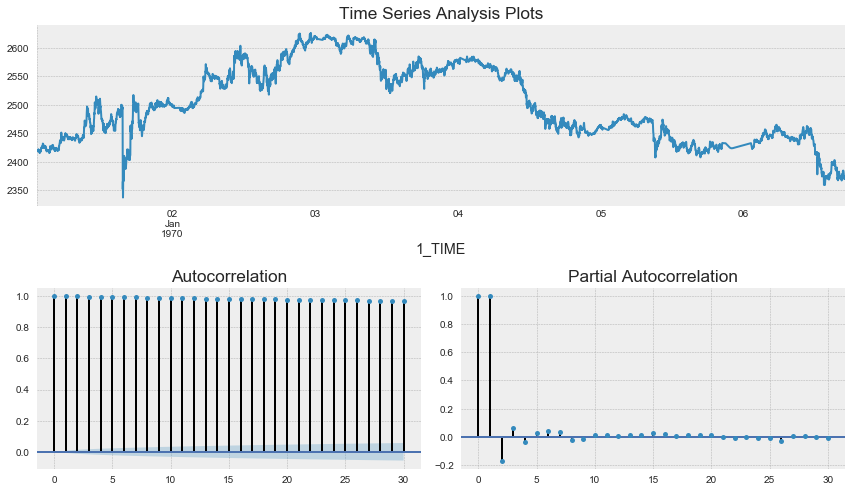

In [12]:
tsplot(tea_agg.BID_P_1, lags=30)

In [13]:
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

In [14]:
def prepareData(data_input, lag_start, lag_end, test_size, outliers_percentage):
    """
    
    data: pd.DataFrame
        initial dataset to break into train and test
        
    lag_start: int
        initial step back in time to slice target variable 
        example - lag_start = 1 means that the model 
                  will see yesterday's values to predict today
        
    lag_end: int
        final step back in time to slice target variable
        example - lag_end = 4 means that the model 
                  will see up to 4 days back in time to predict today
                  
    test_size: int or float
        size of the test dataset after train/test split
        int - exact number of points, float - percentage of dataset
        
    outliers_percentage: boolean/int
        if int value is given - remove int% of outliers from data
        based on the max MSE scores from RandomForestRegressor
    
    """
    
    
    data = pd.DataFrame(data_input)
    data.columns = ['y']
    
    if test_size>1:
        test_index = data.index[len(data)-test_size]
    else:
        test_index = data.index[int(len(data)*(1-test_size))]
    
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    try:
        for i in range(lag_start, lag_end):
            data["last_ticks_trend"] = data["lag_{}".format(i)]/\
                                     data["lag_{}".format(i+1)]
    except:
        pass
        
    #data.index = data.index.to_datetime()
    data["minute"] = pd.Series(data.index).apply(lambda x: x.minute).values
        
    data["minute_average"] = code_mean(data, 'minute', 'y')
    data.drop(["minute"], axis=1, inplace=True)

    
    data = data.dropna()

    X_train = data.loc[:test_index].drop(['y'], axis=1)
    y_train = data.y.loc[:test_index]
    X_test = data.loc[test_index:].drop(['y'], axis=1)
    y_test = data.y.loc[test_index:]
    
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index=X_test.index)
    
    
    if outliers_percentage>0:
        print("removing outliers")
        base_estimator = LinearRegression()
        pred = cross_val_predict(estimator=base_estimator,X=X_train,y=y_train,cv=10)
        error = np.abs(pred-y_train)
        outlier_mask = (error>np.percentile(error, 100-outliers_percentage))
        print("Deleting {} observations from data".format(y_train[outlier_mask].shape[0]))
        X_train = X_train[~outlier_mask.values]
        y_train = y_train[~outlier_mask.values]  
    
    return X_train, X_test, y_train, y_test

In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def importance(model, X_train):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    return coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

def quality(model, X_train, X_test, y_train, y_test):
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)

    constant = np.ones(len(predictions_test))*np.median(y_train)
    text = "константы"
    print("Среднеквадратическая ошибка {}: {}".format(text, mean_squared_error(constant, y_test)))
    print("Среднеквадратическая ошибка train: {}".format(mean_squared_error(predictions_train, y_train)))
    print("Среднеквадратическая ошибка test: {}".format(mean_squared_error(predictions_test, y_test)))
    
    print("MAPE {}: {}".format(text, mean_absolute_percentage_error(constant, y_test)))
    print("MAPE train: {}".format(mean_absolute_percentage_error(predictions_train, y_train)))
    print("MAPE test: {}".format(mean_absolute_percentage_error(predictions_test, y_test)))
    
    print("R2 {}: {}".format(text, r2_score(constant, y_test)))
    print("R2 train: {}".format(r2_score(predictions_train, y_train)))
    print("R2 test: {}".format(r2_score(predictions_test, y_test)))
    
    
def plot_train_test_predictions(model, X_train, X_test, y_train, y_test):
    
    model_values = np.append(model.predict(X_train), model.predict(X_test))
    true_values = np.append(y_train.values, y_test.values)
    
    preds_vs_true = pd.DataFrame([model_values, true_values]).T
    preds_vs_true.columns = ["predictions", "true"]

    ### model prediction chart
    plt.figure(figsize=(15, 4))
    plt.plot(preds_vs_true.true.values, label="Fact values")
    plt.plot(preds_vs_true.predictions.values, label="Predictions")
    plt.axvspan(len(preds_vs_true)-len(y_test), len(preds_vs_true)-1, alpha=0.5, color='lightgrey')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid(True, axis="y")
    plt.title("Mean absolute error {}\n Mean squared error {}"\
              .format(
                  mean_absolute_error(model.predict(X_test), y_test.values),
                  mean_squared_error(model.predict(X_test), y_test.values)
              )
             )
    plt.legend(frameon=True, loc=2, fontsize="large");

## Model for Bid (on full data)

In [16]:
X_train_bid, X_test_bid, y_train_bid, y_test_bid = prepareData(MSK_train[MSK_train['0_ID']=='TEA'].BID_P_1, 
                                                               lag_start=101, lag_end=110, 
                                                               test_size=0.15, outliers_percentage=5)

removing outliers
Deleting 333041 observations from data


In [17]:
model_bid = RidgeCV(alphas=(0.01, 1000, 100), normalize=True, cv=tscv)
model_bid.fit(X_train_bid, y_train_bid)
quality(model_bid, X_train_bid, X_test_bid, y_train_bid, y_test_bid)

Среднеквадратическая ошибка константы: 14184.924183376848
Среднеквадратическая ошибка train: 0.6859654868592022
Среднеквадратическая ошибка test: 0.8637459574475189
MAPE константы: 4.56834924674492
MAPE train: 0.025984599164396667
MAPE test: 0.030615136420826073
R2 константы: 0.0
R2 train: 0.9997949542210789
R2 test: 0.9989224190598126


In [18]:
importance(model_bid, X_train_bid)

,coef
lag_101,6.582460
lag_102,6.562800
lag_103,6.547602
lag_104,6.536662
lag_109,6.533152
lag_108,6.533056
lag_105,6.529591
lag_107,6.527490
lag_106,6.526597
minute_average,0.029330


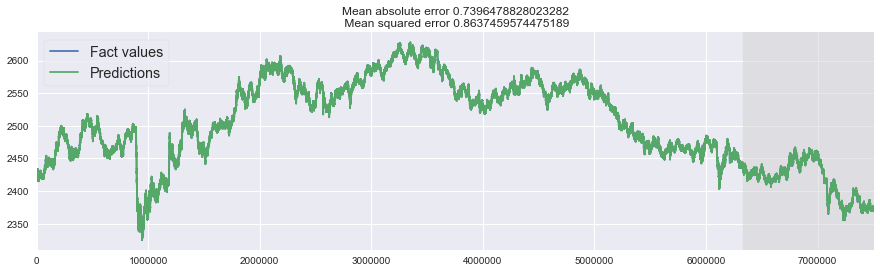

In [19]:
plot_train_test_predictions(model_bid, X_train_bid, X_test_bid, y_train_bid, y_test_bid)

## Model for ask (on full data)

In [20]:
X_train_ask, X_test_ask, y_train_ask, y_test_ask = prepareData(MSK_train[MSK_train['0_ID']=='TEA'].ASK_P_1, lag_start=101, lag_end=110, 
                                               test_size=0.15, outliers_percentage=5)

removing outliers
Deleting 333041 observations from data


In [21]:
model_ask = RidgeCV(alphas=(0.01, 1000, 100), normalize=True, cv=tscv)
model_ask.fit(X_train_ask, y_train_ask)
quality(model_ask, X_train_ask, X_test_ask, y_train_ask, y_test_ask)

Среднеквадратическая ошибка константы: 14156.685530433924
Среднеквадратическая ошибка train: 0.6862229653215357
Среднеквадратическая ошибка test: 0.873303623879258
MAPE константы: 4.56172111856722
MAPE train: 0.025971910008087202
MAPE test: 0.030823903183635877
R2 константы: 0.0
R2 train: 0.9997948445243675
R2 test: 0.9989105197405633


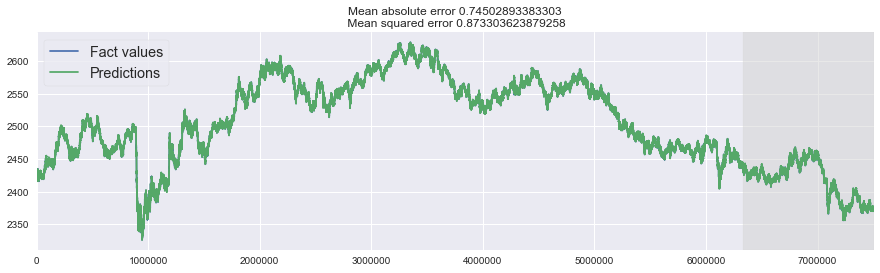

In [22]:
plot_train_test_predictions(model_ask, X_train_ask, X_test_ask, y_train_ask, y_test_ask)

## Predicted volatility

In [23]:
def inverse_rmse(y_true, y_predicted):
    return 10 / mean_squared_error(y_true, y_predicted)

In [24]:
true_volatility = MSK_train[MSK_train['0_ID']=='TEA'].Y[-len(X_test_bid):].values

bids = model_bid.predict(X_test_bid)

asks = model_bid.predict(X_test_ask)

predicted_volatility = pd.Series((bids + asks)/2).rolling(window=100).std().shift(-99)

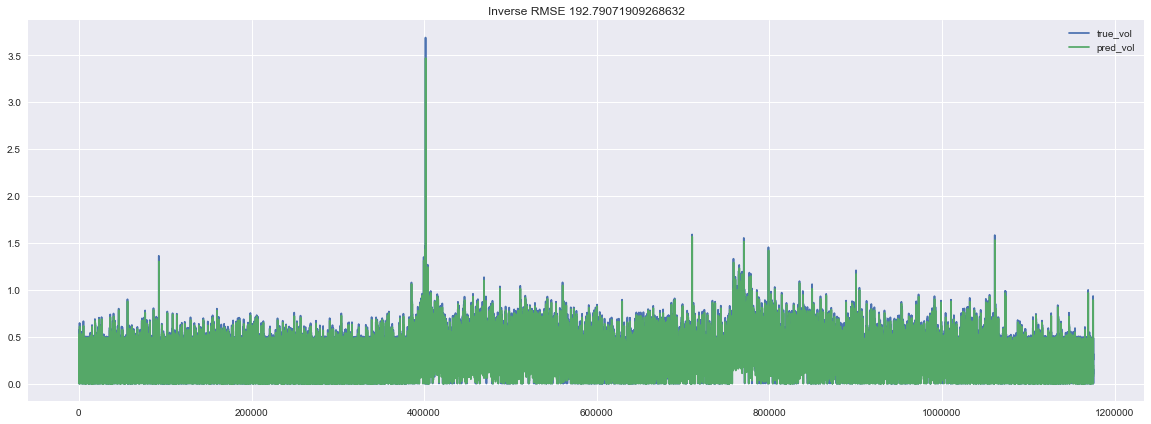

In [25]:
plt.figure(figsize=(20, 7))
plt.plot(true_volatility, label='true_vol')
plt.plot(predicted_volatility, label='pred_vol')
plt.title('Inverse RMSE {}'.format(
        inverse_rmse(true_volatility[~predicted_volatility.isnull()], predicted_volatility.dropna())
))
plt.legend();